## Null hypothesis

The ages of citibike riders are distributed normally.

## Alternative hypothesis

The ages of citibike riders follow some other distribution.

## Secondary null hypothesis

The ages of citibike riders follow a Poisson distribution

In [9]:
from __future__ import print_function
import os
import numpy as np
import scipy.stats as sps
import pylab as pl
%pylab inline
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


In [2]:
# First import the dataset, remove extraneous fields, and remove lines for non-subscribers that
# lack birth year

def getBikeDataCSV(mon):
    # Based loosely on Federica's code
    basename = mon + "-citibike-tripdata"
    zipname = basename + ".zip"
    os.chdir(puidata) # Now all file operations without an absolute path will take place in puidata
    fullfile = puidata + "/" + zipname
    # Check if the file is present
    print("Checking presence of " + zipname)
    print(os.getenv("PWD"))
    if os.path.isfile(puidata + "/" + basename + ".csv"):
        print("Already have the file")
        return
    if os.path.isfile(basename + ".csv"):
        print("Found file " + basename + ".csv")
        if os.path.isfile(mon + "-citibike-tripdata.csv"):
            if os.system("mv " + mon + "-citibike-tripdata.csv " + puidata):
                print("Could not move file to " + puidata)
                return
    else:
        print("Downloading file " + zipname)
        if not os.path.isfile(fullfile):
            os.system("curl -O " + sitename + "/" + zipname)
            if os.path.isfile(fullfile):
                print("Got " + zipname + "\n")
                os.system("unzip -q " + fullfile)
            else:
                print("Failed\n")
                return
            
def in_rect(ptlat, ptlon, contour):
    # ptlat - scalar latitude of the coordinate being tested
    # ptlon - scalar longitude of the coordinate being tested
    # contour - tuple of coordinates bounding polygon
    # First look for two pairs of points in contour where
    # which ptlat is between
    bet_segs = []
    eq_pt = []
    try:
        for corner in range(0, len(contour)):
            if between(ptlat, contour[corner][0], contour[(corner + 1) % len(contour)][0]):
                bet_segs.append(corner)
            elif ptlat == contour[corner][0]:
                eq_pt.append(corner)
    except ValueError:
        return False
    # If there were no segments, return False
    if len(bet_segs) <= 1 and len(eq_pt) == 0:
        return False
    # If there is one equal to a vertex and none inside segment,
    # return whether it is on the vertex
    if len(eq_pt) == 1 and len(bet_segs) == 0:
        return ptlon == contour[eq_pt[0]][1]
    # If there are two equal to a vertex and none inside segment,
    # return whether it is on the line connecting those vertices, including ends
    if len(eq_pt) == 2 and len(bet_segs) == 0:
        return between(ptlon, contour[eq_pt[0]][1], contour[eq_pt[1]][1]
                      ) or ptlon == contour[eq_pt[0]][1] or ptlon == contour[eq_pt[1]][1]
    # If there are two or more segments, find the longitude-intercepts
    # for each of those segments with the latitude and return whether or
    # not the point is on a longitude in between
    if len(bet_segs) >= 2:
        xint_list = []
        # Find the longitude on each segment in the list intersecting the latitude
        for ver in bet_segs:
            xint = x_intercept(ptlat, ptlon, (contour[ver], contour[(ver+1) % len(contour)]))
            xint_list.append(xint)
        lessthan_lon = 0
        # If the number of segments with an x-intercept greater than the points x-coordinate
        # is odd, the point is in the polygon
        for xi in xint_list:
            if xi == ptlon:
                # On the segment
                return True
            if xi < ptlon:
                lessthan_lon += 1
        return (lessthan_lon % 2) == 1

def x_intercept(ptlat, ptlon, seg_ends):
    # Return the x-coordinate of the segment defined by seg_ends that has a y-coordinate of ptlat
    if seg_ends[0][0] == seg_ends[1][0]:
        if ptlat == seg_ends[0][0]:
            if between(ptlon, seg_ends[0][1], seg_ends[1][1]):
                return ptlon
            else:
                return Null
        else:
            return Null
    if seg_ends[0][1] == seg_ends[1][1]:
        return seg_ends[0][1]
    y_frac = (ptlat - seg_ends[0][0]) / (seg_ends[1][1] - seg_ends[0][1])
    x_int = seg_ends[0][1] + y_frac * (seg_ends[1][1] - seg_ends[0][1])
    return x_int

def between (compare, st, en):
    if st < compare and compare < en:
        return True
    if en < compare and compare < st:
        return True
    return False

In [7]:
sitename = "http://s3.amazonaws.com/tripdata"
puidata = os.getenv("PUIDATA")
initmon = "201501"
getBikeDataCSV(initmon)
df = pd.read_csv(puidata + "/" + initmon + "-citibike-tripdata.csv")
csvcols = df.keys()
holdcols = ["start station id", "start station name", "start station latittude",
            "start station longitude", "birth year", "usertype"]
dropcols = []
for col in csvcols:
    if not col in holdcols: dropcols.append(col)
df.drop(dropcols, axis=1, inplace=True)
df = df[df["usertype"] == "Subscriber"]
for appmon in range(2,13):
    append_file = "2015{:02d}".format(appmon)
    getBikeDataCSV(append_file)
    appdf = pd.read_csv(puidata + "/" + append_file + "-citibike-tripdata.csv")
    appdf.drop(dropcols, axis=1, inplace=True)
    appdf = appdf[appdf["usertype"] == 'Subscriber']
    df = df.append(appdf, ignore_index=True)
df.shape

Checking presence of 201501-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW5_ss4977
Already have the file
Checking presence of 201502-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW5_ss4977
Already have the file
Checking presence of 201503-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW5_ss4977
Already have the file
Checking presence of 201504-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW5_ss4977
Already have the file
Checking presence of 201505-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW5_ss4977
Already have the file
Checking presence of 201506-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW5_ss4977
Already have the file
Checking presence of 201507-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW5_ss4977
Already have the file
Checking presence of 201508-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW5_ss4977
Already have the file
Checking presenc

(8626638, 5)

In [8]:
df["age"] = 2016 - df["birth year"]
df.shape

(8626638, 6)

In [11]:
# Provide some statistics about the age distribution
# The third and fourth moments provide a quick indication about what type of distribution is present

agemean = df.age.mean()
agevar = df.age.var()
ageskew = sps.skew(df.age, nan_policy='omit')
agekurt = sps.kurtosis(df.age, fisher=True, nan_policy='omit')
print(agemean)
print(agevar)
print(ageskew)
print(agekurt)

39.4466903554
133.823339893
0.709454618038
0.41305009734


The skew of .709 is just under $\sqrt{2}$ and the excess kurtosis is just under 1/2. Based on that, we will try a poisson distribution with $\lambda=2$, adjusted to fit the mean and variance.

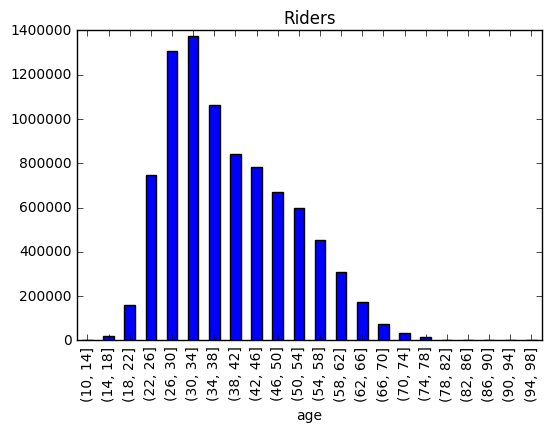

In [13]:
# visualize the distribution

bins = np.arange(10, 99, 4)
agegrp = df.age.groupby(pd.cut(df.age, bins))
ageagg = agegrp.agg([np.count_nonzero])
ax = ageagg.plot(kind='bar', legend=False)
ax.set_title('Riders')

In [16]:
cumage = ageagg.cumsum()
normage = cumage / cumage.max()

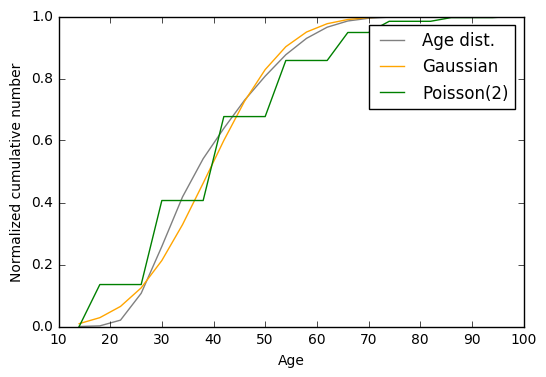

In [51]:
np.random.seed(1024)
agevec = df.age
agevec.dropna(inplace=True)
gauss_dist = pd.Series(np.random.randn(agevec.count()) * np.sqrt(133) + 39)
# The following produces a distribution with mean 39 and variance 133, like that of the age
# distribution of riders, and the skew and kurtosis of Poisson(2)
pois_dist = pd.Series((np.random.poisson(2, agevec.count()) - 2) * np.sqrt(133) + 39)
gauss_grp = gauss_dist.groupby(pd.cut(gauss_dist, bins))
pois_grp = pois_dist.groupby(pd.cut(pois_dist, bins))
gauss_agg = gauss_grp.agg([np.count_nonzero])
pois_agg = pois_grp.agg([np.count_nonzero])
gauss_cum = gauss_agg.cumsum()
pois_cum = pois_agg.cumsum()
gauss_norm = gauss_cum / gauss_cum.max()
pois_norm = pois_cum / pois_cum.max()
# Visualize the cdf's of the sample and simulated gaussian and poisson distributions
pl.plot(bins[:-1] + 4, normage, label="Age dist.", color="grey")
pl.plot(bins[:-1] + 4, gauss_norm, label="Gaussian", color="orange")
pl.plot(bins[:-1] + 4, pois_norm, label="Poisson(2)", color="green")
pl.xlabel("Age")
pl.ylabel("Normalized cumulative number")
pl.legend()

In [58]:
agevec = df.age
agevec.dropna(inplace=True)
age2gauss_ks = sps.ks_2samp(agevec, gauss_dist)
age2gauss_ch2 = sps.chisquare(f_obs=ageagg, f_exp=gauss_agg)
age2gauss_ad = sps.anderson(agevec, dist='norm')
print("The statistics for gaussian are:")
print("By Kolmogorov-Smirnov: " + str(age2gauss_ks))
print("By Chi square: " + str(age2gauss_ch2))
print("By Anderson-Darling: " + str(age2gauss_ad))
age2pois_ks = sps.ks_2samp(agevec, pois_dist)
print("\nThe statistics for Poisson(2) are:")
print("By Kolmogorov-Smirnov: " + str(age2pois_ks))
age2pois_ch2 = sps.chisquare(f_obs=ageagg, f_exp=pois_agg)
print("By Chi square: " + str(age2pois_ch2))
age2pois_ad = sps.anderson_ksamp([ageagg, pois_agg])
print("By Anderson-Darling: " + str(age2pois_ad))

The statistics for gaussian are:
By Kolmogorov-Smirnov: Ks_2sampResult(statistic=0.08859757000285276, pvalue=0.0)
By Chi square: Power_divergenceResult(statistic=array([ 1261207.87358977]), pvalue=array([ 0.]))
By Anderson-Darling: AndersonResult(statistic=117824.95259504393, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

The statistics for Poisson(2) are:
By Kolmogorov-Smirnov: Ks_2sampResult(statistic=0.26173363267841027, pvalue=0.0)


TypeError: chisquare() got an unexpected keyword argument 'nan_policy'

The null hypothesis can be rejected for both distributions. The p-value for the Kolmogorov-Smirnov and Chi square tests were too small to measure for both normal and poisson distribution. In addition, the Anderson-Darling score was orders of magnitude larger than the 1% significance level for the normal distribution.